In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from math import sqrt
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
import shap

In [2]:
#Train and validation dataset
df = pd.read_csv('train_q_lig.csv')

In [3]:
#Test dataset
dt = pd.read_csv('test_q_lig.csv')

## Data preparation

In [4]:
y = df.Shift.to_numpy()

X = df.drop(['Complex', 'Shift', 'Source_doi', 'Brutto', 'Charge_class', 'Geometry', 'Ligand', 'Smiles'], axis=1)
columns = X.columns
X = X.to_numpy()

In [5]:
y_test = dt.Shift.to_numpy()
X_test = dt.drop(['Complex', 'Shift', 'Source_doi', 'Brutto', 'Charge_class', 'Geometry', 'Ligand', 'Smiles'], axis=1).to_numpy()

In [6]:
scaler_train = StandardScaler()

scaler_train.fit(X)
scaler_train.fit(X_test)

X_norm = scaler_train.transform(X)
X_test_norm = scaler_train.transform(X_test)

## Some useful functions

In [7]:
def evaluate_res(model, X_test, y_test):
    residuals = (y_test - model.predict(X_test))
    rmsd = sqrt(np.sum(residuals ** 2) / float(len(y_test)))
    print('RMSD = {:0.2f} ppm'.format(rmsd))   
    return rmsd


def plot_rmsd(model, X, y):
    plt.plot(y, y, color='r', linestyle='-', linewidth=3)
    plt.plot(y, model.predict(X), linestyle='none', marker='o')

    plt.xlabel("Exp. δ")
    plt.ylabel("Pred. δ")
    plt.show()
    
    return evaluate_res(model, X, y)

In [8]:
def tune_hyperparam(estimator, grid, X, y):
    
    est_random = RandomizedSearchCV(estimator=estimator, param_distributions = grid, n_iter = 100, 
                                    cv = 5, verbose=2, random_state=42, n_jobs = -1)
    est_random.fit(X, y)
    print(est_random.best_params_)
    print('Mean of R2', est_random.best_score_)
    
    return est_random.best_estimator_

In [9]:
def evaluate(estimator, X, y, n_splits, scoring):
    
    cv = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)
    scores = cross_val_score(estimator, X, y, cv=cv, scoring=scoring)
    
    if scoring == 'r2':
        print('Mean =', np.mean(scores), 'Std =', np.std(scores), 'Min =', np.min(scores))
        
    if scoring == 'neg_mean_absolute_error':
        scores = [-i for i in scores]
        print('Mean =', np.mean(scores), 'Std =', np.std(scores), 'Min =', np.min(scores))
        
    if scoring == 'neg_mean_squared_error':
        scores = [np.sqrt(-i) for i in scores]
        print('Mean =', np.mean(scores), 'Std =', np.std(scores), 'Min =', np.min(scores))
        
    return {'Mean':np.mean(scores), 'Std': np.std(scores), 'Min': np.min(scores)}

## Models: Random Forest, Ridge regressor, SVR

### Hyperprameter tuning by use of grid search

In [10]:
#Random forest grid
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 20)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 205, num = 22)]
max_depth.append(None)
min_samples_split = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_leaf = [1, 2, 3, 4]
bootstrap = [True, False]
warm_start = [True, False]
grid_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'warm_start': warm_start}
# pprint(grid_rf)

In [11]:
#Ridge regression grid
alpha = [1.e-0, 1.e-1, 1.e-2, 1.e-3, 1.e-4, 1.e-5, 1.e-6, 1.e-7, 1.e-8, 1.e-9, 1.e-10]
coef0 = np.linspace(1.e-10, 1, 50)
degree = [0, 1, 2, 3, 4]
gamma = [1.e-0, 1.e-1, 1.e-2, 1.e-3, 1.e-4, 1.e-5, 1.e-6, 1.e-7, 1.e-8, 1.e-9, 1.e-10]
kernel = ['laplacian', 'RBF', 'polynomial', 'exponential chi2', 'sigmoid']

grid_ridge = {'alpha': alpha,
         'coef0': coef0,
         'degree': degree,
         'gamma': gamma,
         'kernel': kernel}

# pprint(grid_ridge)


In [12]:
#SVR grid
C = [10000, 100000, 1000000, 10000000]
coef0 = [1.e-0, 1.e-1, 1.e-2, 1.e-3, 1.e-4, 1.e-5, 1.e-6, 1.e-7, 1.e-8, 1.e-9, 1.e-10]
degree = [1, 2, 3, 4, 5]
epsilon = [1.e-0, 1.e-1, 1.e-2, 1.e-3, 1.e-4, 1.e-5, 1.e-6, 1.e-7, 1.e-8, 1.e-9, 1.e-10]
gamma = ['scale', 'auto']
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
tol = [1.e-1, 1.e-2, 1.e-3, 1.e-4, 1.e-5, 1.e-6, 1.e-7, 1.e-8, 1.e-9, 1.e-10]
max_iter = 1000000

grid_svr = {'C' : C,
     'coef0': coef0,
     'degree': degree,
     'epsilon': epsilon,
     'gamma': gamma,
     'kernel': kernel,
     'tol': tol}
# pprint(grid_svr)

In [13]:
#Models with hyperparameters to be fine-tuned
rf = RandomForestRegressor()
ridge = KernelRidge()
svr = SVR(max_iter=max_iter)
estimators = {rf: grid_rf, ridge: grid_ridge, svr: grid_svr}

In [14]:
best_estim = []
for i, j in estimators.items():
    best_estim.append(tune_hyperparam(i, j, X_norm, y))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, max_depth=147, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=1000, warm_start=True; total time=   4.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=687, warm_start=False; total time=   3.2s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=687, warm_start=False; total time=   2.3s
[CV] END bootstrap=False, max_depth=176, max_features=auto, min_samples_leaf=2, min_samples_split=9, n_estimators=322, warm_start=True; total time=   1.3s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=374, warm_start=True; total time=   1.4s
[CV] END bootstrap=False, max_depth=138, max_features=auto, min_samples_leaf=4, min_samples_split=7, n_estimators=1000, warm_start=False; total time=   4.4s
[

[CV] END bootstrap=True, max_depth=128, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=166, warm_start=True; total time=   0.2s[CV] END bootstrap=False, max_depth=147, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=1000, warm_start=True; total time=   3.6s
[CV] END bootstrap=False, max_depth=147, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=1000, warm_start=True; total time=   5.6s
[CV] END bootstrap=False, max_depth=176, max_features=auto, min_samples_leaf=2, min_samples_split=9, n_estimators=322, warm_start=True; total time=   1.3s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=374, warm_start=True; total time=   1.6s
[CV] END bootstrap=False, max_depth=138, max_features=auto, min_samples_leaf=4, min_samples_split=7, n_estimators=1000, warm_start=False; total time=   4.6s
[CV] END bootstrap=False, max_depth=109, max_features=auto, min_sampl

[CV] END bootstrap=True, max_depth=205, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=739, warm_start=True; total time=   5.1s[CV] END bootstrap=False, max_depth=147, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=1000, warm_start=True; total time=   3.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=687, warm_start=False; total time=   3.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=687, warm_start=False; total time=   2.5s
[CV] END bootstrap=False, max_depth=176, max_features=auto, min_samples_leaf=2, min_samples_split=9, n_estimators=322, warm_start=True; total time=   1.2s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=374, warm_start=True; total time=   1.5s
[CV] END bootstrap=False, max_depth=138, max_features=auto, min_samp

[CV] END bootstrap=True, max_depth=205, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=739, warm_start=True; total time=   4.3s[CV] END bootstrap=False, max_depth=147, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=1000, warm_start=True; total time=   4.4s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=687, warm_start=False; total time=   3.2s
[CV] END bootstrap=False, max_depth=176, max_features=auto, min_samples_leaf=2, min_samples_split=9, n_estimators=322, warm_start=True; total time=   1.5s
[CV] END bootstrap=False, max_depth=176, max_features=auto, min_samples_leaf=2, min_samples_split=9, n_estimators=322, warm_start=True; total time=   1.5s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=374, warm_start=True; total time=   1.5s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples


40 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/opt/miniconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/miniconda3/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt

{'warm_start': False, 'n_estimators': 114, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 195, 'bootstrap': True}
Mean of R2 0.33536062884481455
Fitting 5 folds for each of 100 candidates, totalling 500 fits

[CV] END bootstrap=False, max_depth=147, max_features=sqrt, min_samples_leaf=3, min_samples_split=7, n_estimators=62, warm_start=False; total time=   0.4s
[CV] END bootstrap=False, max_depth=147, max_features=sqrt, min_samples_leaf=3, min_samples_split=7, n_estimators=62, warm_start=False; total time=   0.5s
[CV] END bootstrap=False, max_depth=138, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=374, warm_start=True; total time=   1.5s
[CV] END bootstrap=False, max_depth=138, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=374, warm_start=True; total time=   1.4s
[CV] END bootstrap=False, max_depth=147, max_features=sqrt, min_samples_leaf=3, min_samples_split=9, n_estimators=1000, warm_start=Tru

[CV] END bootstrap=True, max_depth=185, max_features=auto, min_samples_leaf=3, min_samples_split=7, n_estimators=478, warm_start=True; total time=   1.9s
[CV] END bootstrap=True, max_depth=24, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=843, warm_start=True; total time=   3.4s
[CV] END bootstrap=True, max_depth=205, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=739, warm_start=True; total time=   4.0s
[CV] END bootstrap=True, max_depth=205, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=739, warm_start=True; total time=   4.8s
[CV] END bootstrap=False, max_depth=147, max_features=sqrt, min_samples_leaf=3, min_samples_split=9, n_estimators=1000, warm_start=True; total time=   3.1s
[CV] END bootstrap=True, max_depth=147, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=895, warm_start=False; total time=   5.4s
[CV] END bootstrap=True, max_depth=52, max_features=auto, min_samples_lea

[CV] END bootstrap=True, max_depth=81, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=374, warm_start=True; total time=   1.5s
[CV] END bootstrap=False, max_depth=166, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=843, warm_start=True; total time=   2.9s
[CV] END bootstrap=True, max_depth=33, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=687, warm_start=True; total time=   2.4s
[CV] END bootstrap=True, max_depth=119, max_features=auto, min_samples_leaf=1, min_samples_split=7, n_estimators=531, warm_start=True; total time=   2.3s
[CV] END bootstrap=True, max_depth=119, max_features=auto, min_samples_leaf=1, min_samples_split=7, n_estimators=531, warm_start=True; total time=   2.3s
[CV] END bootstrap=False, max_depth=185, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=843, warm_start=False; total time=   3.0s
[CV] END bootstrap=True, max_depth=81, max_features=auto, min_samples_leaf=


185 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
110 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/kernel_ridge.py", line 197, in fit
    K = self._get_kernel(X)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/kernel_ridge.py", line 155, in _get_kernel
    return pairwise_kernels(X, Y, metric=self.kernel, filter_params=True, **params)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py", line 2051, in pairw


[CV] END bootstrap=True, max_depth=43, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=687, warm_start=True; total time=   2.7s
[CV] END bootstrap=True, max_depth=185, max_features=auto, min_samples_leaf=3, min_samples_split=7, n_estimators=478, warm_start=True; total time=   2.0s
[CV] END bootstrap=True, max_depth=185, max_features=auto, min_samples_leaf=3, min_samples_split=7, n_estimators=478, warm_start=True; total time=   1.9s
[CV] END bootstrap=False, max_depth=166, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=843, warm_start=True; total time=   2.6s
[CV] END bootstrap=True, max_depth=33, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=687, warm_start=True; total time=   2.4s
[CV] END bootstrap=True, max_depth=33, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=687, warm_start=True; total time=   2.4s
[CV] END bootstrap=True, max_depth=119, max_features=auto, min_samples_leaf=

[CV] END alpha=0.0001, coef0=0.9183673469469388, degree=1, gamma=0.1, kernel=laplacian; total time=   0.0s
[CV] END bootstrap=True, max_depth=195, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=635, warm_start=False; total time=   2.5s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=218, warm_start=True; total time=   0.6s
[CV] END bootstrap=True, max_depth=71, max_features=auto, min_samples_leaf=1, min_samples_split=7, n_estimators=583, warm_start=True; total time=   2.5s
[CV] END bootstrap=True, max_depth=24, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=843, warm_start=True; total time=   3.0s
[CV] END bootstrap=True, max_depth=24, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=843, warm_start=True; total time=   3.0s
[CV] END bootstrap=False, max_depth=119, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=218, war

[CV] END alpha=1e-06, coef0=0.30612244904897956, degree=3, gamma=0.001, kernel=polynomial; total time=   0.0s
[CV] END alpha=1e-06, coef0=0.14285714294285715, degree=4, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END alpha=1e-08, coef0=0.734693877577551, degree=4, gamma=1e-10, kernel=sigmoid; total time=   0.0s
[CV] END alpha=1e-08, coef0=0.734693877577551, degree=4, gamma=1e-10, kernel=sigmoid; total time=   0.0s
[CV] END alpha=1e-08, coef0=0.734693877577551, degree=4, gamma=1e-10, kernel=sigmoid; total time=   0.0s
[CV] END alpha=1e-09, coef0=0.04081632662653061, degree=1, gamma=1.0, kernel=exponential chi2; total time=   0.0s
[CV] END alpha=1e-09, coef0=0.04081632662653061, degree=1, gamma=1.0, kernel=exponential chi2; total time=   0.0s
[CV] END alpha=1e-09, coef0=0.04081632662653061, degree=1, gamma=1.0, kernel=exponential chi2; total time=   0.0s
[CV] END alpha=1e-09, coef0=0.04081632662653061, degree=1, gamma=1.0, kernel=exponential chi2; total time=   0.0s
[CV] END alpha

[CV] END alpha=0.01, coef0=0.5714285714714286, degree=0, gamma=0.0001, kernel=polynomial; total time=   0.0s
[CV] END alpha=0.0001, coef0=0.9183673469469388, degree=1, gamma=0.1, kernel=laplacian; total time=   0.0s
[CV] END alpha=0.0001, coef0=0.9183673469469388, degree=1, gamma=0.1, kernel=laplacian; total time=   0.0s
[CV] END alpha=0.0001, coef0=0.12244897967959183, degree=4, gamma=0.001, kernel=RBF; total time=   0.0s
[CV] END alpha=0.0001, coef0=0.12244897967959183, degree=4, gamma=0.001, kernel=RBF; total time=   0.0s
[CV] END alpha=0.0001, coef0=0.12244897967959183, degree=4, gamma=0.001, kernel=RBF; total time=   0.0s
[CV] END alpha=1.0, coef0=0.6326530612612244, degree=4, gamma=1e-09, kernel=polynomial; total time=   0.0s
[CV] END alpha=1.0, coef0=0.6326530612612244, degree=4, gamma=1e-09, kernel=polynomial; total time=   0.0s
[CV] END alpha=1.0, coef0=0.6326530612612244, degree=4, gamma=1e-09, kernel=polynomial; total time=   0.0s
[CV] END alpha=1.0, coef0=0.6326530612612244

[CV] END C=10000000, coef0=1.0, degree=2, epsilon=1e-09, gamma=auto, kernel=rbf, tol=1e-08; total time=   0.3s
[CV] END alpha=0.01, coef0=0.5714285714714286, degree=0, gamma=0.0001, kernel=polynomial; total time=   0.0s
[CV] END alpha=0.01, coef0=0.5714285714714286, degree=0, gamma=0.0001, kernel=polynomial; total time=   0.0s
[CV] END C=1000000, coef0=1e-05, degree=4, epsilon=1e-06, gamma=scale, kernel=sigmoid, tol=1e-09; total time=   0.0s
[CV] END C=10000000, coef0=1.0, degree=2, epsilon=1e-09, gamma=auto, kernel=rbf, tol=1e-08; total time=   1.6s
[CV] END C=100000, coef0=0.1, degree=3, epsilon=0.0001, gamma=scale, kernel=linear, tol=1e-07; total time=   1.5s
[CV] END C=1000000, coef0=1e-09, degree=2, epsilon=1.0, gamma=auto, kernel=poly, tol=1e-08; total time=   0.5s
[CV] END C=1000000, coef0=1e-09, degree=2, epsilon=1.0, gamma=auto, kernel=poly, tol=1e-08; total time=   1.6s
[CV] END C=1000000, coef0=1e-09, degree=2, epsilon=1.0, gamma=auto, kernel=poly, tol=1e-08; total time=   1

[CV] END C=10000000, coef0=0.0001, degree=5, epsilon=1e-06, gamma=auto, kernel=linear, tol=1e-06; total time=   2.9s
[CV] END alpha=1e-06, coef0=0.3469387755755102, degree=2, gamma=1e-05, kernel=exponential chi2; total time=   0.0s
[CV] END alpha=1e-06, coef0=0.3469387755755102, degree=2, gamma=1e-05, kernel=exponential chi2; total time=   0.0s
[CV] END alpha=1e-06, coef0=0.3469387755755102, degree=2, gamma=1e-05, kernel=exponential chi2; total time=   0.0s
[CV] END alpha=1e-06, coef0=0.3469387755755102, degree=2, gamma=1e-05, kernel=exponential chi2; total time=   0.0s
[CV] END alpha=1e-06, coef0=0.3469387755755102, degree=2, gamma=1e-05, kernel=exponential chi2; total time=   0.0s
[CV] END alpha=1e-10, coef0=0.30612244904897956, degree=1, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END alpha=1e-10, coef0=0.30612244904897956, degree=1, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END alpha=1e-10, coef0=0.30612244904897956, degree=1, gamma=0.001, kernel=sigmoid; total 

[CV] END alpha=1.0, coef0=0.6122448979979591, degree=2, gamma=1e-06, kernel=polynomial; total time=   0.0s
[CV] END C=1000000, coef0=1e-05, degree=1, epsilon=1e-06, gamma=auto, kernel=rbf, tol=1e-07; total time=   0.1s
[CV] END C=1000000, coef0=1e-05, degree=1, epsilon=1e-06, gamma=auto, kernel=rbf, tol=1e-07; total time=   0.1s
[CV] END C=100000, coef0=0.0001, degree=2, epsilon=1e-06, gamma=auto, kernel=sigmoid, tol=1e-06; total time=   0.0s
[CV] END C=100000, coef0=0.0001, degree=2, epsilon=1e-06, gamma=auto, kernel=sigmoid, tol=1e-06; total time=   0.0s
[CV] END C=100000, coef0=0.1, degree=5, epsilon=1e-07, gamma=scale, kernel=linear, tol=1e-07; total time=   1.6s
[CV] END C=100000, coef0=0.0001, degree=1, epsilon=1e-10, gamma=scale, kernel=linear, tol=0.0001; total time=   0.5s
[CV] END C=100000, coef0=0.0001, degree=1, epsilon=1e-10, gamma=scale, kernel=linear, tol=0.0001; total time=   0.8s
[CV] END C=10000, coef0=1e-07, degree=1, epsilon=1e-09, gamma=scale, kernel=sigmoid, tol=0

[CV] END C=1000000, coef0=1.0, degree=3, epsilon=1e-09, gamma=scale, kernel=poly, tol=1e-10; total time=   2.3s{'tol': 0.1, 'kernel': 'poly', 'gamma': 'auto', 'epsilon': 1e-07, 'degree': 2, 'coef0': 1e-09, 'C': 10000}
Mean of R2 0.3419391451690631


In [15]:
best_estim

[RandomForestRegressor(max_depth=195, min_samples_leaf=3, min_samples_split=4,
                       n_estimators=114),
 KernelRidge(alpha=0.0001, coef0=0.734693877577551, degree=0, gamma=1e-05,
             kernel='laplacian'),
 SVR(C=10000, coef0=1e-09, degree=2, epsilon=1e-07, gamma='auto', kernel='poly',
     max_iter=1000000, tol=0.1)]

### Training and models evaluation by use of cross-validation

In [16]:
res_r2 = []
for i in best_estim:
    res_r2.append(evaluate(i, X_norm, y, n_splits=5, scoring='r2'))
res_df_r2 = pd.DataFrame(res_r2, index=['RF', 'Ridge regr', 'SVR'])
res_df_r2

Mean = 0.73606004269646 Std = 0.18893677762782612 Min = 0.3888606184470905
Mean = 0.7636963611593527 Std = 0.12678125759619666 Min = 0.6107791785891146
Mean = 0.5226366925127968 Std = 0.4534151525651317 Min = -0.19597832773996915


,Mean,Std,Min
RF,0.736060,0.188937,0.388861
Ridge regr,0.763696,0.126781,0.610779
SVR,0.522637,0.453415,-0.195978


In [17]:
res_mae = []
for i in best_estim:
    res_mae.append(evaluate(i, X_norm, y, n_splits=5, scoring='neg_mean_absolute_error'))
res_df_mae = pd.DataFrame(res_mae, index=['RF', 'Ridge regr', 'SVR'])
res_df_mae

Mean = 818.9734016938226 Std = 186.22232833970762 Min = 631.0971614192337
Mean = 733.8092665255256 Std = 192.61014735687593 Min = 562.049169472605
Mean = 842.4019897540195 Std = 246.30635850016998 Min = 559.5880965505644


,Mean,Std,Min
RF,818.973402,186.222328,631.097161
Ridge regr,733.809267,192.610147,562.049169
SVR,842.401990,246.306359,559.588097


In [18]:
res_rmse = []
for i in best_estim:
    res_rmse.append(evaluate(i, X_norm, y, n_splits=5, scoring='neg_mean_squared_error'))
res_df_rmse = pd.DataFrame(res_rmse, index=['RF', 'Ridge regr', 'SVR'])
res_df_rmse

Mean = 1214.4317781207087 Std = 276.18824101434916 Min = 861.7634438262808
Mean = 1181.6808996217428 Std = 297.20773693334576 Min = 781.0873416527927
Mean = 1428.2810306172078 Std = 599.4541340421788 Min = 703.4650174956976


,Mean,Std,Min
RF,1214.431778,276.188241,861.763444
Ridge regr,1181.680900,297.207737,781.087342
SVR,1428.281031,599.454134,703.465017


RandomForestRegressor(max_depth=195, min_samples_leaf=3, min_samples_split=4,
                      n_estimators=114)


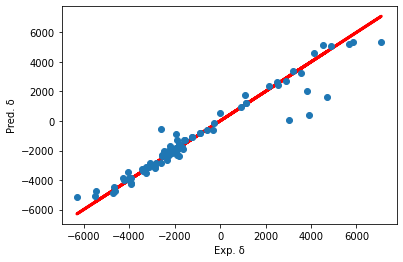

RMSD = 706.19 ppm


KernelRidge(alpha=0.0001, coef0=0.734693877577551, degree=0, gamma=1e-05,
            kernel='laplacian')


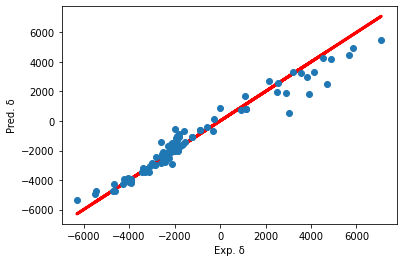

RMSD = 620.76 ppm


SVR(C=10000, coef0=1e-09, degree=2, epsilon=1e-07, gamma='auto', kernel='poly',
    max_iter=1000000, tol=0.1)


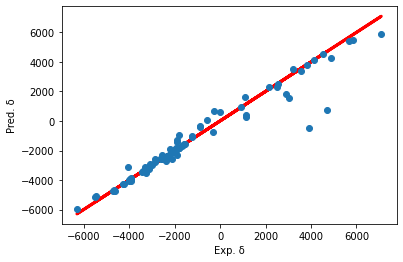

RMSD = 695.86 ppm




In [19]:
for i in best_estim:
    print(i)
    plot_rmsd(i, X_norm, y)
    print('\n')

## Test the model on held-out data

RandomForestRegressor(max_depth=195, min_samples_leaf=3, min_samples_split=4,
                      n_estimators=114)


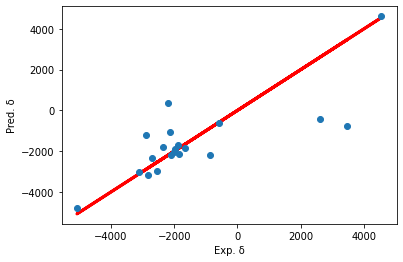

RMSD = 1425.85 ppm


KernelRidge(alpha=0.0001, coef0=0.734693877577551, degree=0, gamma=1e-05,
            kernel='laplacian')


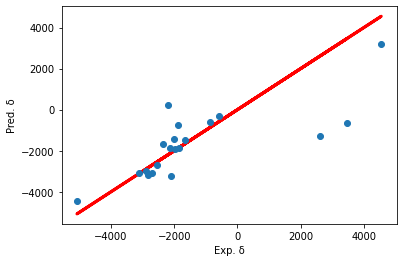

RMSD = 1484.27 ppm


SVR(C=10000, coef0=1e-09, degree=2, epsilon=1e-07, gamma='auto', kernel='poly',
    max_iter=1000000, tol=0.1)


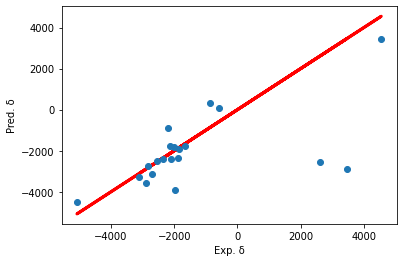

RMSD = 1958.05 ppm




In [20]:
for i in best_estim:
    print(i)
    plot_rmsd(i, X_test_norm, y_test)
    print('\n')

## Models explanation

In [21]:
columns

Index(['Charge', 'Dipole', 'q', 'q_lig', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31',
       '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43',
       '44', '45', '46'],
      dtype='object')

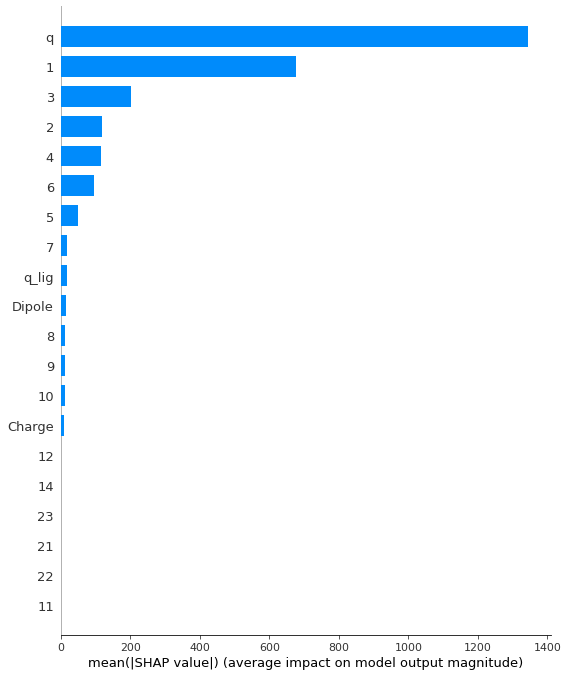

In [22]:
#RandomForest
shap_values = shap.Explainer(best_estim[0]).shap_values(X_norm)
shap.summary_plot(shap_values, X_test_norm, plot_type="bar", feature_names = columns)

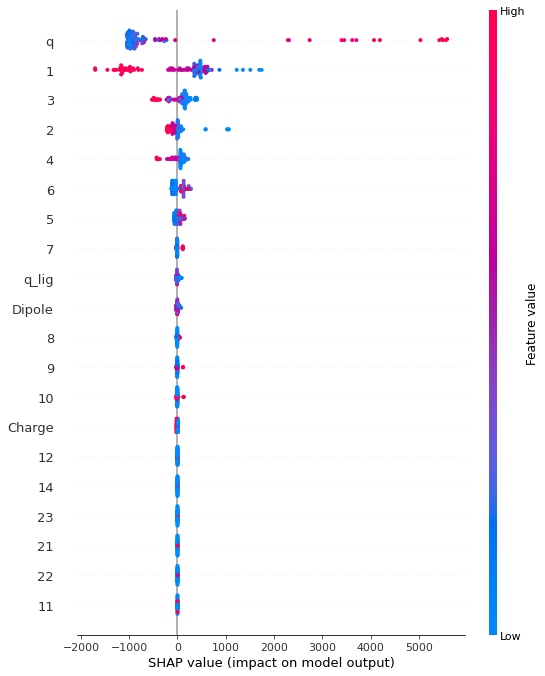

In [23]:
shap.summary_plot(shap_values, X_norm, feature_names = columns)

Permutation explainer: 101it [00:22,  3.16it/s]                                 


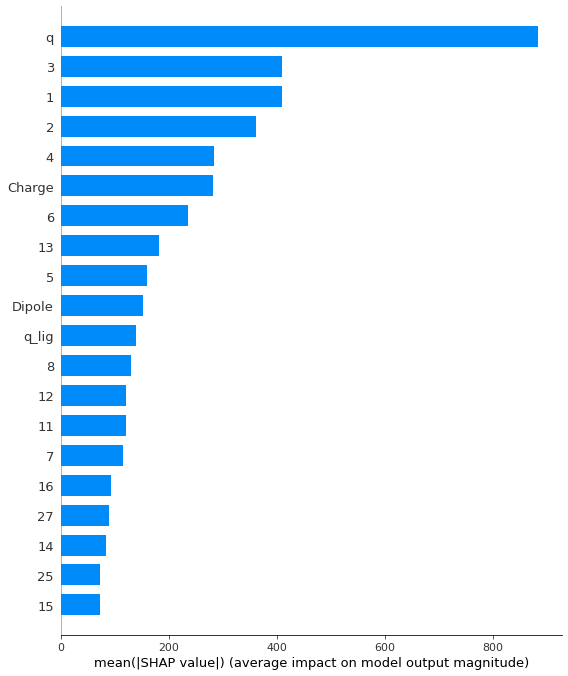

In [24]:
#Ridge Regression
explainer = shap.Explainer(best_estim[1].predict, X_norm)
shap_values = explainer(X_norm)
shap.summary_plot(shap_values, X_norm, plot_type="bar", feature_names = columns)

Permutation explainer: 101it [00:16,  2.31it/s]                                 


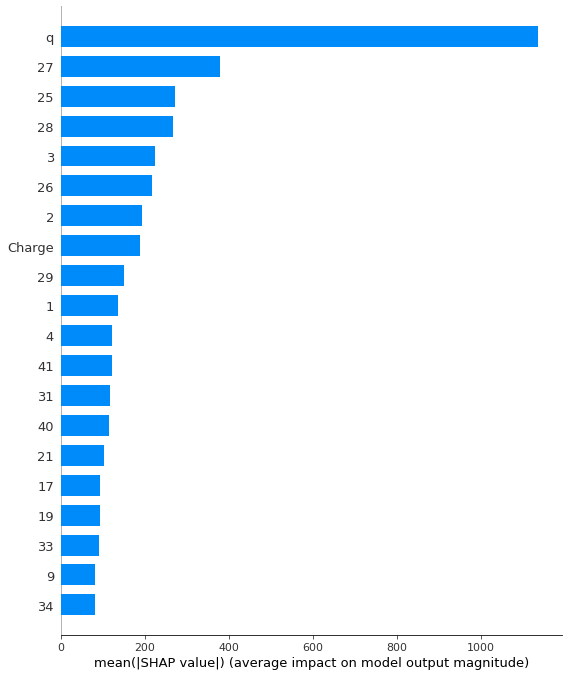

In [25]:
#SVR
explainer = shap.Explainer(best_estim[2].predict, X_norm, feature_names = columns)
shap_values = explainer(X_norm)
shap.summary_plot(shap_values, X_norm, plot_type="bar", feature_names = columns)